# Naive Bayes Classifier

In this notebook, we train a Naive Bayes classifier on the training set for prediction with scikit-learn module.

### 1. Data Loading

We first load the training set and the test set (.NPY files).

In [1]:
import numpy as np
xs_test = np.load('data/xs_test.npy')
xs_train = np.load('data/xs_train.npy')
ys_test = np.load('data/ys_test.npy')
ys_train = np.load('data/ys_train.npy')

What's more, the dictionary files (.CSV) which contains the string categorical values and the corresponding integer codes are also loaded.

In [2]:
import csv

class_dic = {}

# read the .csv files back to the dictionaries
with open('data/class_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        class_dic[row[0]] = row[1]

### 2. Parameter Tuning

We have chosen the Gaussian Naive Bayes model to train on our dataset. To realise this specific model, we utilize the GaussianNB() method of sklearn package.

Before doing hyperparameter tuning, we first check what parameters do GaussianNB() model have.

According to the output, GaussianNB() only has the following two parameters:

- <b>priors:</b> Prior probabilities of the categories. If not specified, it will be adjusted according to the amount of data.

- <b>var_smoothing:</b> A float parameter which represents the portion of the largest variance of all features being added to variances for calculation stability.



In [3]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Take a look at which parameters can be fine tuned
GaussianNB_params = list(GaussianNB().get_params().keys())
print("Parameters of GaussianNB:", GaussianNB_params)

Parameters of GaussianNB: ['priors', 'var_smoothing']


Since we don't have the prior probabilities of the categories, we only try to tune the <b>var_smoothing</b> parameter.

To find the best var_smoothing, we do the grid search on the training set which will try each possible value of the parameter and find the one leading to the highest weighted F1 score.

What's more, we also do 3-repeated Stratified 5-Fold cross validation when doing grid search to get a reliable estimate of how well each model performs on the unseen data. In this case, The model will be trained and evaluated 1500 times using 1500 different parameters.

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

# Create a Gaussian Classifier model
model = GaussianNB()

# Define grid search parameters
params_grid_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

# define the cross validation method
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=999)

gs_NB = GridSearchCV(estimator=model, 
                 param_grid=params_grid_NB, 
                 cv=cv_method,
                 verbose=1, 
                 scoring='f1_weighted') 

# Learn a naive bayes algorithm on the training set.
gs_NB.fit(xs_train, ys_train.ravel())


print("Best Score: ", gs_NB.best_score_)
print("Best Params: ", gs_NB.best_params_)


Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Best Score:  0.8253806036741419
Best Params:  {'var_smoothing': 0.03511191734215131}


According to the output, the Gaussian Naive Bayes model got the best weighted F1 score (0.8254) when the var_smoothing is set as approximately 0.035.

### 3. Model Training and Evaluation

Then, using the best <b>var_smoothing</b> value, we learn a Gaussian Naive Bayes on the training set.

In [5]:
# Create and train a Gaussian Classifier model with the best var_smoothing
GNB = GaussianNB(var_smoothing=gs_NB.best_params_['var_smoothing'])
GNB.fit(xs_train, ys_train.ravel())


GaussianNB(var_smoothing=0.03511191734215131)

In order to use the trained model again in the Model Ensemble Part, we save the model with joblib() method in sklearn.

In [6]:
import joblib
# save the trained model
joblib.dump(GNB, 'models/Gaussian_Naive_Bayes.model')

['models/Gaussian_Naive_Bayes.model']

Finally, we evaluate the model by making classification reports both on the traing set and on the test set.

According to the results, the metrics on the training set and test set are all similar, which indicates that there is no obvious overfitting in our model.

<b>In general, overfitting is not something that should be a concern with Naive Bayes as it makes a strong assumption of independence between the features, so it is biased and less flexible, hence less likely to overfit. </b>

In [7]:
from sklearn.metrics import classification_report

# predict the ys with xs of training set and test set
ys_train_pred = GNB.predict(xs_train)
ys_test_pred = GNB.predict(xs_test)

# print the classfication report
print('Classification Report of Naive Bayes on the Training set: \n\n',classification_report(ys_train, ys_train_pred,digits=4))
print('Classification Report of Naive Bayes on the Test set: \n\n',classification_report(ys_test, ys_test_pred,digits=4))

Classification Report of Naive Bayes on the Training set: 

               precision    recall  f1-score   support

           0     0.8723    0.9525    0.9106       968
           1     0.7066    0.5570    0.6230       307
           2     0.8846    0.8846    0.8846        52
           3     0.6129    0.3455    0.4419        55

    accuracy                         0.8379      1382
   macro avg     0.7691    0.6849    0.7150      1382
weighted avg     0.8256    0.8379    0.8271      1382

Classification Report of Naive Bayes on the Test set: 

               precision    recall  f1-score   support

           0     0.8444    0.9421    0.8906       242
           1     0.6909    0.4935    0.5758        77
           2     0.8571    0.9231    0.8889        13
           3     0.7143    0.3571    0.4762        14

    accuracy                         0.8179       346
   macro avg     0.7767    0.6790    0.7079       346
weighted avg     0.8055    0.8179    0.8037       346



We also plot a confusion matrix heatmap with the heatmap() method in seaborn package to evaluate the classification performance of the model on each class.

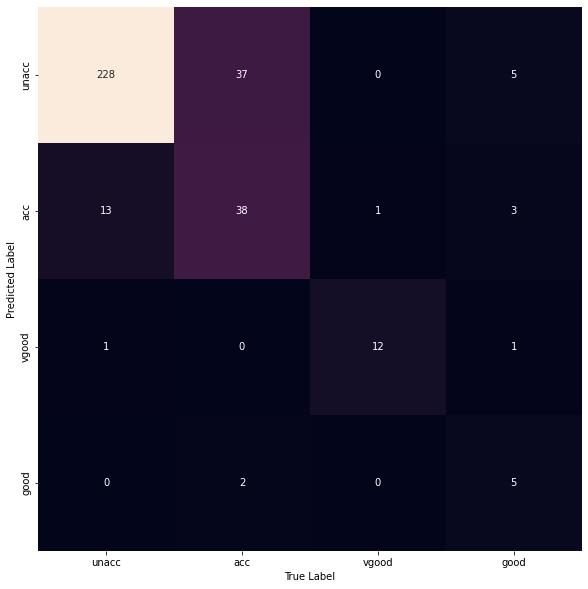

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# construct a confusion matrix which shows the accuracy on each class
mat = confusion_matrix(ys_test, ys_test_pred)

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()
